<a href="https://colab.research.google.com/github/VamsiPutheti12/ML-DL/blob/main/Hand_written_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 607kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.07MB/s]


Starting training...
Epoch: 1 [0/60000 (0%)]	Loss: 2.295132
Epoch: 1 [6400/60000 (11%)]	Loss: 0.374815
Epoch: 1 [12800/60000 (21%)]	Loss: 0.206123
Epoch: 1 [19200/60000 (32%)]	Loss: 0.140003
Epoch: 1 [25600/60000 (43%)]	Loss: 0.116906
Epoch: 1 [32000/60000 (53%)]	Loss: 0.205479
Epoch: 1 [38400/60000 (64%)]	Loss: 0.067133
Epoch: 1 [44800/60000 (75%)]	Loss: 0.087272
Epoch: 1 [51200/60000 (85%)]	Loss: 0.095823
Epoch: 1 [57600/60000 (96%)]	Loss: 0.072064

Test set: Average loss: 0.0725, Accuracy: 9778/10000 (97.78%)

Epoch: 2 [0/60000 (0%)]	Loss: 0.037541
Epoch: 2 [6400/60000 (11%)]	Loss: 0.122568
Epoch: 2 [12800/60000 (21%)]	Loss: 0.171677
Epoch: 2 [19200/60000 (32%)]	Loss: 0.010232
Epoch: 2 [25600/60000 (43%)]	Loss: 0.072920
Epoch: 2 [32000/60000 (53%)]	Loss: 0.048870
Epoch: 2 [38400/60000 (64%)]	Loss: 0.031580
Epoch: 2 [44800/60000 (75%)]	Loss: 0.016208
Epoch: 2 [51200/60000 (85%)]	Loss: 0.116673
Epoch: 2 [57600/60000 (96%)]	Loss: 0.011894

Test set: Average loss: 0.0340, Accuracy: 9885

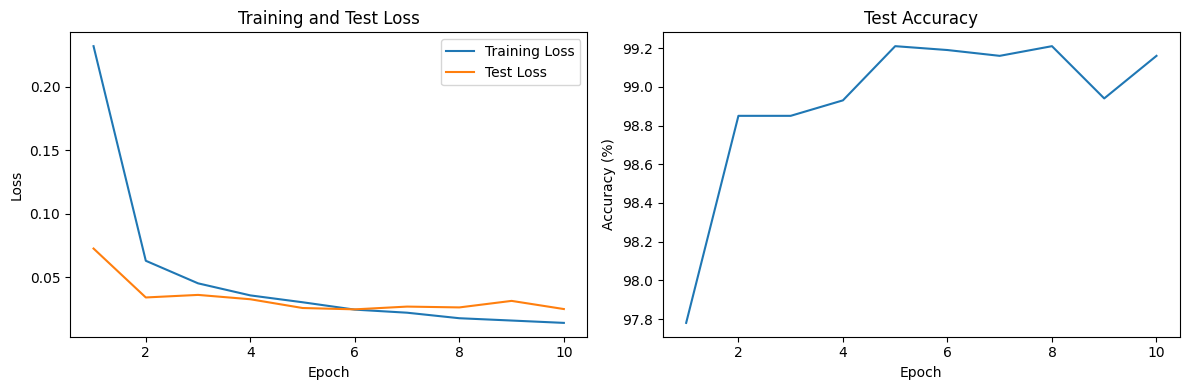

Model saved as 'mnist_cnn.pth'
Visualizing predictions...


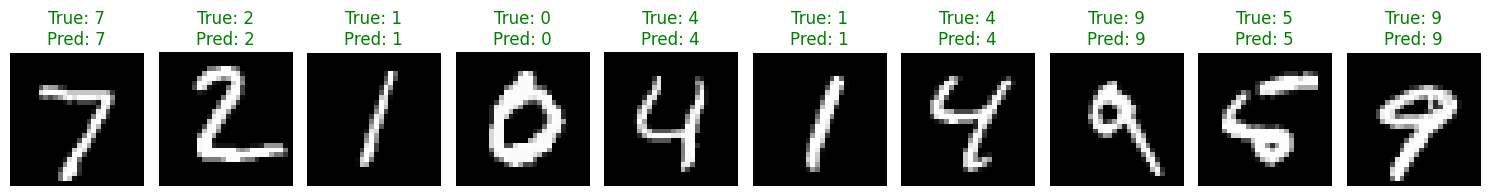

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 10

# Data transforms
# We normalize the data to have mean 0 and standard deviation 1, which helps training
transform = transforms.Compose([
    transforms.ToTensor(),                     # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize using MNIST mean and std
])

# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the neural network model
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        # First convolutional layer
        # Input: 1x28x28, Output: 32x26x26
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)

        # Second convolutional layer
        # Input: 32x13x13 (after pooling), Output: 64x11x11
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout2d(0.25)

        # First fully connected layer
        # After second pooling, we have 64x5x5 features
        self.fc1 = nn.Linear(64 * 5 * 5, 128)

        # Output layer (10 classes for digits 0-9)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First conv -> ReLU -> pooling
        x = F.relu(self.conv1(x))                  # Apply first convolution and ReLU
        x = F.max_pool2d(x, 2)                     # Apply 2x2 max pooling

        # Second conv -> ReLU -> pooling
        x = F.relu(self.conv2(x))                  # Apply second convolution and ReLU
        x = F.max_pool2d(x, 2)                     # Apply 2x2 max pooling

        # Dropout for regularization
        x = self.dropout(x)

        # Reshape tensor for fully connected layer
        x = x.view(-1, 64 * 5 * 5)                 # Flatten the tensor

        # First fully connected layer
        x = F.relu(self.fc1(x))                    # Apply first fully connected layer and ReLU

        # Output layer
        x = self.fc2(x)                            # Apply output layer

        # Return log softmax probabilities
        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and loss function
model = DigitClassifier().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = F.nll_loss

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # Set model to training mode
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Print progress
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    return avg_loss

# Testing function
def test(model, device, test_loader):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0

    # No need to track gradients during evaluation
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)

            # Accumulate loss
            test_loss += criterion(output, target, reduction='sum').item()

            # Get predictions
            pred = output.argmax(dim=1, keepdim=True)

            # Count correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate average loss and accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return test_loss, accuracy

# Function to visualize model predictions
def visualize_predictions(model, device, test_loader, num_samples=10):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # Make predictions
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Move tensors back to CPU for plotting
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    # Plot images with true and predicted labels
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        color = 'green' if predicted[i] == labels[i] else 'red'
        axes[i].set_title(f'True: {labels[i]}\nPred: {predicted[i]}', color=color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Lists to store metrics for plotting
train_losses = []
test_losses = []
accuracies = []

# Train the model
print("Starting training...")
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, device, test_loader)

    # Store metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

# Plot training progress
plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')

plt.tight_layout()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'mnist_cnn.pth')
print("Model saved as 'mnist_cnn.pth'")

# Visualize some predictions
print("Visualizing predictions...")
visualize_predictions(model, device, test_loader)

# Function to make predictions on a single image
def predict_digit(image_path):
    from PIL import Image
    import numpy as np

    # Load and preprocess the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize((28, 28))

    # Convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.exp(output)
        prediction = output.argmax(dim=1, keepdim=True).item()
        confidence = probabilities[0][prediction].item() * 100

    print(f"Predicted digit: {prediction} with {confidence:.2f}% confidence")

    return prediction, confidence

# Example usage of the predict_digit function:
# predict_digit('your_digit_image.png')